# Proyek Klasifikasi Gambar: Flowers Dataset
- **Nama:** Gymnastiar Harun
- **Email:** gimnnastiarhrn@gmail.com
- **ID Dicoding:** gimnastiarhrn

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import pathlib
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Data Preparation

In [2]:
#from google.colab import files
#files.upload()

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/5-flower-types-classification-dataset


In [7]:
dataset_dir = pathlib.Path('/kaggle/input/5-flower-types-classification-dataset/flower_images')

### Data Loading

In [8]:
# Buat folder baru untuk dataset yang sudah dibagi
base_dir = 'flowers_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk membuat folder jika belum ada
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

make_dir(train_dir)
make_dir(val_dir)
make_dir(test_dir)

# Ambil semua kelas (nama folder)
class_names = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Buat folder kelas di train, val, test
for cls in class_names:
    make_dir(os.path.join(train_dir, cls))
    make_dir(os.path.join(val_dir, cls))
    make_dir(os.path.join(test_dir, cls))

# Kumpulkan semua file gambar dan labelnya
file_paths = []
labels = []

for cls in class_names:
    cls_folder = os.path.join(dataset_dir, cls)
    files = os.listdir(cls_folder)
    for f in files:
        file_paths.append(os.path.join(cls_folder, f))
        labels.append(cls)

# Bagi dataset menjadi train dan temp
train_files, temp_files, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.4, stratify=labels, random_state=42)

# Bagi temp menjadi validation dan test
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Fungsi untuk copy file ke folder tujuan
def copy_files(file_list, label_list, target_dir):
    for file_path, label in zip(file_list, label_list):
        dest_dir = os.path.join(target_dir, label)
        shutil.copy(file_path, dest_dir)

# Copy file ke folder train, val, test
copy_files(train_files, train_labels, train_dir)
copy_files(val_files, val_labels, val_dir)
copy_files(test_files, test_labels, test_dir)

print("Pembagian dataset selesai.")
print(f"Train set: {len(train_files)} gambar")
print(f"Validation set: {len(val_files)} gambar")
print(f"Test set: {len(test_files)} gambar")

Pembagian dataset selesai.
Train set: 3000 gambar
Validation set: 1000 gambar
Test set: 1000 gambar


### Data Preprocessing

#### Split Dataset

In [10]:
# Tambahkan data augmentasi pada pipeline data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='wrap'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = (224, 224)  # Ukuran gambar bisa disesuaikan
BATCH_SIZE = 32

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_ds.class_indices.keys())
num_classes = len(class_names)
print("Kelas:", class_names)


# Terapkan augmentasi pada train_ds
#train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimasi pipeline data
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 3000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Kelas: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


## Modelling

In [15]:
model = models.Sequential([
    Input(shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    #layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,830,085 (37.50 MB)

 Trainable params: 9,828,613 (37.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1)

In [18]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 546ms/step - accuracy: 0.4043 - loss: 2.0044 - val_accuracy: 0.2000 - val_loss: 2.1778 - learning_rate: 5.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - accuracy: 0.5178 - loss: 1.4231 - val_accuracy: 0.2930 - val_loss: 1.7707 - learning_rate: 5.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 461ms/step - accuracy: 0.5458 - loss: 1.2429 - val_accuracy: 0.3240 - val_loss: 1.6876 - learning_rate: 5.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 463ms/step - accuracy: 0.5661 - loss: 1.1884 - val_accuracy: 0.4450 - val_loss: 1.4832 - learning_rate: 5.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - accuracy: 0.6097 - loss: 1.0625 - val_accuracy: 0.5600 - val_loss: 1.0830 - learning_rate: 5.0000e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - accuracy: 0.6204 - loss: 1.0311 - val_accuracy: 0.5420 - val_loss: 1.1941 - learning_rate: 5.0000e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - acc

## Evaluasi dan Visualisasi

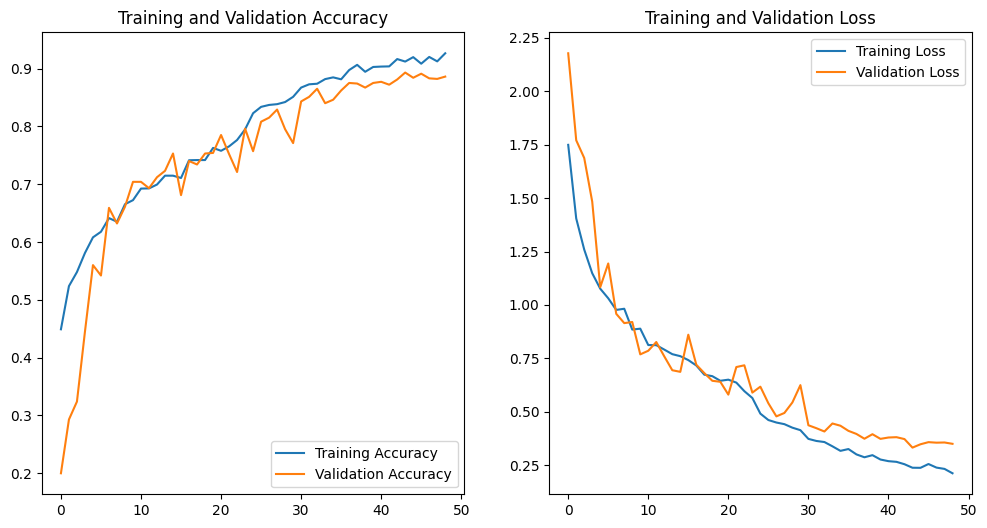

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Akurasi pada test set: {test_acc*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8756 - loss: 0.4161
Akurasi pada test set: 88.00%


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step
Confusion Matrix:
[[173  14   8   0   5]
 [ 16 173   4   0   7]
 [ 12   7 176   2   3]
 [  5   0   0 195   0]
 [ 16   9   5   7 163]]


<Axes: >

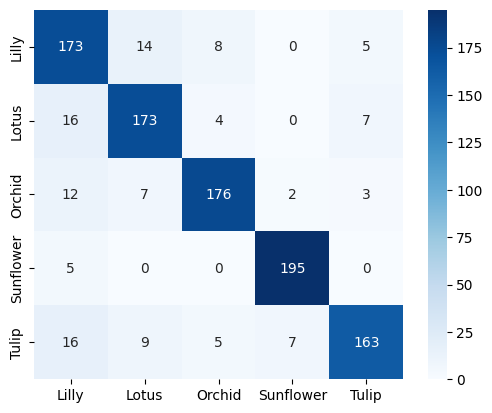

In [24]:
# make predictions on test data
test_predictions = model.predict(test_ds)

# convert predictions from one-hot encoding to class labels
test_labels = np.argmax(test_predictions, axis=1)

# get true labels of test data
true_labels = test_ds.classes

# compute confusion matrix
cm = confusion_matrix(true_labels, test_labels)

# display confusion matrix
print('Confusion Matrix:')
print(cm)

sns.heatmap(cm ,annot=True, cmap= "Blues", fmt="d", square=True,
            xticklabels=class_names, yticklabels=class_names)


## Konversi Model

In [25]:
saved_model_dir = 'saved_model' # Changed to a directory name without extension
tf.saved_model.save(model, saved_model_dir) # Save the model as a SavedModel

# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # Update the path here
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


# Konversi ke TFJS
# Perlu install tensorflowjs terlebih dahulu di environment kamu

!pip install tensorflowjs
import subprocess
subprocess.run(['tensorflowjs_converter', '--input_format', 'tf_saved_model',
                '--output_format', 'tfjs_graph_model', saved_model_dir, 'tfjs_model'])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


CompletedProcess(args=['tensorflowjs_converter', '--input_format', 'tf_saved_model', '--output_format', 'tfjs_graph_model', 'saved_model', 'tfjs_model'], returncode=0)

## Inference (Optional)

In [40]:
!pip install pipreqs
from google.colab import drive
drive.mount('/content/drive')
!pipreqs "/content/drive/MyDrive/Colab Notebooks" --scan-notebooks


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/requirements.txt
